In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_validate, KFold
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, StackingRegressor, VotingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor

from sklearn.pipeline import Pipeline

import keras

import joblib

In [2]:
df = pd.read_csv('crop_yield.csv')
df.head()

,Crop,Precipitation,SpecificHumidity_g_kg,RelativeHumidity_%,Temperature_C,Yield
0,"Cocoa, beans",2248.92,17.72,83.40,26.01,11560
1,"Cocoa, beans",1938.42,17.54,82.11,26.11,11253
2,"Cocoa, beans",2301.54,17.81,82.79,26.24,9456
3,"Cocoa, beans",2592.35,17.61,85.07,25.56,9321
4,"Cocoa, beans",2344.72,17.61,84.12,25.76,8800


### Pré-Processamento dos dados

Como já realizamos a análise exploratória dos dados, podemos partir para a preparação dos dados para o algoritmo de Machine Learning.

**Tratamento dos dados categóricos**

O parâmetro *drop-first=True* serve para evitar multicolinearidade entre os dados, ou seja, variáveis que se correlacionam entre si.

In [3]:
crop = pd.get_dummies(df, columns=['Crop'], drop_first=True)
df = pd.concat([df['Crop'], crop], axis=1)
df.head()

,Crop,Precipitation,SpecificHumidity_g_kg,RelativeHumidity_%,Temperature_C,Yield,Crop_Oil palm fruit,"Crop_Rice, paddy","Crop_Rubber, natural"
0,"Cocoa, beans",2248.92,17.72,83.40,26.01,11560,False,False,False
1,"Cocoa, beans",1938.42,17.54,82.11,26.11,11253,False,False,False
2,"Cocoa, beans",2301.54,17.81,82.79,26.24,9456,False,False,False
3,"Cocoa, beans",2592.35,17.61,85.07,25.56,9321,False,False,False
4,"Cocoa, beans",2344.72,17.61,84.12,25.76,8800,False,False,False


**Combinação das 2 features de humidade**

In [4]:
df['HumidityCombined'] = df['RelativeHumidity_%'] * df['SpecificHumidity_g_kg'] # Combinação das features

df.drop(['SpecificHumidity_g_kg', 'RelativeHumidity_%'], axis=1, inplace=True) # Excluindo valores de humidade anteriores
df.head()

,Crop,Precipitation,Temperature_C,Yield,Crop_Oil palm fruit,"Crop_Rice, paddy","Crop_Rubber, natural",HumidityCombined
0,"Cocoa, beans",2248.92,26.01,11560,False,False,False,1477.8480
1,"Cocoa, beans",1938.42,26.11,11253,False,False,False,1440.2094
2,"Cocoa, beans",2301.54,26.24,9456,False,False,False,1474.4899
3,"Cocoa, beans",2592.35,25.56,9321,False,False,False,1498.0827
4,"Cocoa, beans",2344.72,25.76,8800,False,False,False,1481.3532


**Separando variáveis independentes (X) da variável dependente (y)**

In [ ]:
# TODO: Talvez seja necessário fazer algum tipo de tratamento com os outliers de rendimento, pois existem vários.

X = df[['Crop','Crop_Oil palm fruit', 'Crop_Rice, paddy', 'Precipitation', 'HumidityCombined', 'Temperature_C']]
y = df['Yield']

**Separação dos dados em treino e teste**

Método HoldOut, porém também faremos validação cruzada.

É realizado uma **estratificação** pela cultura (Crop) para cada exemplo.

In [6]:
SEED = 80

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=X['Crop'], random_state=SEED)

X_train['Crop'].value_counts()

Crop
Cocoa, beans       31
Rubber, natural    31
Rice, paddy        31
Oil palm fruit     31
Name: count, dtype: int64

In [7]:
X_test['Crop'].value_counts()

Crop
Cocoa, beans       8
Rubber, natural    8
Rice, paddy        8
Oil palm fruit     8
Name: count, dtype: int64

In [8]:
X_train.drop('Crop', axis=1, inplace=True)
X_test.drop('Crop', axis=1, inplace=True)
X.drop('Crop', axis=1, inplace=True)

C:\Users\Diogo Botton\AppData\Local\Temp\ipykernel_39200\152154555.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.drop('Crop', axis=1, inplace=True)


**Normalização**

In [9]:
normalization = MinMaxScaler()

X_train = normalization.fit_transform(X_train)
X_test = normalization.transform(X_test)

### Treinamento com vários modelos

In [10]:
def view_scores(y_true, y_pred, title):
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(title)
    print(f'MSE: {mse}')
    print(f'RMSE: {np.sqrt(mse)}')
    print(f'R² Score: {r2*100:.2f}')

In [11]:
def cros_validate_view_scores(results):
   mse_scores = -results['test_neg_mean_squared_error'].mean() # Realiza a média e converte para valores positivos
   r2_scores = results['test_r2'].mean() # Realiza a média e converte para valores positivos
   
   print(f'MSE: {mse_scores}')
   print(f'RMSE: {np.sqrt(mse_scores)}')
   print(f'R²: {r2_scores}')

In [12]:
kfold = KFold(n_splits=10, shuffle=True, random_state=SEED)

#### Modelo Baseline

In [13]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

model_lr_predict = model_lr.predict(X_test)
view_scores(y_test, model_lr_predict, 'Modelo Baseline (Logistic Regression)')

Modelo Baseline (Logistic Regression)
MSE: 88491091.52423547
RMSE: 9406.970369052699
R² Score: 98.24


**Validação cruzada**

OBS: Para problemas de regressão, é necessário utilizar o KFold.

In [14]:
pipeline_lr = Pipeline([
    ('scaler', MinMaxScaler()),
    ('estimator', LinearRegression())
])

results_lr = cross_validate(pipeline_lr, X, y,
                            cv=kfold,
                            scoring=['neg_mean_squared_error', 'r2'])
cros_validate_view_scores(results_lr)

MSE: 63796420.58010224
RMSE: 7987.266151825807
R²: 0.9857091410803847


#### Voting Regressor

In [15]:
base_models = [
    ('dt', DecisionTreeRegressor(random_state=SEED)),
    ('rt', RandomForestRegressor(n_estimators=100, random_state=SEED)),
    ('knn', KNeighborsRegressor()),
    ('svc', SVR()),
    ('lr', LinearRegression())
]

model_bg = VotingRegressor(estimators=base_models)
model_bg.fit(X_train, y_train)

model_bg_predict = model_bg.predict(X_test)
view_scores(y_test, model_bg_predict, 'Voting Regressor')

Voting Regressor
MSE: 407957541.0302174
RMSE: 20197.958833263758
R² Score: 91.88


**Validação Cruzada**

In [16]:
pipeline_vt = Pipeline([
    ('scaler', MinMaxScaler()),
    ('estimator', VotingRegressor(estimators=base_models))
])

results_vt = cross_validate(pipeline_vt, X, y,
                            cv=kfold,
                            scoring=['neg_mean_squared_error', 'r2'])
cros_validate_view_scores(results_vt)

MSE: 326629122.63104314
RMSE: 18072.88362799482
R²: 0.9347059551639847


#### Stacking

In [17]:
model_st = StackingRegressor(estimators=base_models,
                             final_estimator=DecisionTreeRegressor(random_state=SEED))
model_st.fit(X_train, y_train)

model_st_predict = model_st.predict(X_test)
view_scores(y_test, model_st_predict, 'Stacking')

Stacking
MSE: 122313161.1875
RMSE: 11059.528072549027
R² Score: 97.57


**Validação Cruzada**

In [18]:
pipeline_stc = Pipeline([
    ('scaler', MinMaxScaler()),
    ('estimator', StackingRegressor(estimators=base_models,
                             final_estimator=DecisionTreeRegressor(random_state=SEED)))
])

results_stc = cross_validate(pipeline_stc, X, y,
                            cv=kfold,
                            scoring=['neg_mean_squared_error', 'r2'])
cros_validate_view_scores(results_stc)

MSE: 144103160.73208332
RMSE: 12004.297594281947
R²: 0.9713342627873043


#### Floresta Aleatória

In [19]:
model_rf = RandomForestRegressor(random_state=SEED)
model_rf.fit(X_train, y_train)

model_rf_predict = model_rf.predict(X_test)
view_scores(y_test, model_rf_predict, 'Floresta Aleatória')

Floresta Aleatória
MSE: 110111113.87078229
RMSE: 10493.384290627228
R² Score: 97.81


**Validação Cruzada**

In [20]:
pipeline_rf = Pipeline([
    ('scaler', MinMaxScaler()),
    ('estimator', RandomForestRegressor(random_state=SEED))
])

results_rf = cross_validate(pipeline_rf, X, y,
                            cv=kfold,
                            scoring=['neg_mean_squared_error', 'r2'])
cros_validate_view_scores(results_rf)

MSE: 56225466.882245764
RMSE: 7498.364280444486
R²: 0.9878509996350626


#### Bagging Regressor

In [21]:
model_bg = BaggingRegressor(estimator=LinearRegression(), random_state=SEED)
model_bg.fit(X_train, y_train)

model_bg_predict = model_bg.predict(X_test)
view_scores(y_test, model_bg_predict, 'Bagging Regressor')

Bagging Regressor
MSE: 87400464.8261419
RMSE: 9348.821574195428
R² Score: 98.26


**Validação Cruzada**

In [22]:
pipeline_bg = Pipeline([
    ('scaler', MinMaxScaler()),
    ('estimator', BaggingRegressor(estimator=LinearRegression(), random_state=SEED))
])

results_bg = cross_validate(pipeline_bg, X, y,
                            cv=kfold,
                            scoring=['neg_mean_squared_error', 'r2'])
cros_validate_view_scores(results_bg)

MSE: 63243434.74110867
RMSE: 7952.574095291956
R²: 0.9857591418519032


#### XGBoost

In [23]:
model_xgb = XGBRegressor()
model_xgb.fit(X_train, y_train)

model_xgb_predict = model_xgb.predict(X_test)
view_scores(y_test, model_xgb_predict, 'XGBoost Regressor')

XGBoost Regressor
MSE: 113593981.8719972
RMSE: 10658.04775144103
R² Score: 97.74


**Validação Cruzada**

In [24]:
pipeline_xgb = Pipeline([
    ('scaler', MinMaxScaler()),
    ('estimator', XGBRegressor())
])

results_xgb = cross_validate(pipeline_xgb, X, y,
                            cv=kfold,
                            scoring=['neg_mean_squared_error', 'r2'])
cros_validate_view_scores(results_xgb)

MSE: 78923854.00488426
RMSE: 8883.90983772822
R²: 0.9830909132957458


#### Redes Neurais

Apesar de redes neurais serem poderosas, nem sempre é a melhor escolha.

In [25]:
model_keras = keras.Sequential([
    keras.layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(1, activation='linear')
])

c:\Users\Diogo Botton\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [26]:
model_keras.compile(optimizer=keras.optimizers.Adam(),
                    loss=keras.losses.MeanSquaredError(),
                    metrics=[keras.metrics.R2Score(), keras.metrics.RootMeanSquaredError()])

model_keras.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 45,313 (177.00 KB)

 Trainable params: 45,313 (177.00 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
             keras.callbacks.ModelCheckpoint(monitor='val_loss',
                                             filepath='checkpoint_best_model.keras', save_best_only=True)]

In [28]:
history = model_keras.fit(X_train, y_train,
                epochs=150,
                batch_size=32,
                validation_data=(X_test, y_test),
                callbacks=callbacks)

Epoch 1/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - loss: 9158677504.0000 - r2_score: -0.7218 - root_mean_squared_error: 95425.6719 - val_loss: 8223321088.0000 - val_r2_score: -0.6362 - val_root_mean_squared_error: 90682.5312
Epoch 2/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 8301335552.0000 - r2_score: -0.6595 - root_mean_squared_error: 91072.8281 - val_loss: 8223316992.0000 - val_r2_score: -0.6362 - val_root_mean_squared_error: 90682.5078
Epoch 3/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 8314864128.0000 - r2_score: -0.6576 - root_mean_squared_error: 91152.7031 - val_loss: 8223309312.0000 - val_r2_score: -0.6362 - val_root_mean_squared_error: 90682.4609
Epoch 4/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 7783533568.0000 - r2_score: -0.6412 - root_mean_squared_error: 88132.9297 - val_loss: 8223297536.0000 - val_r2_score: -0.6362 - val_root_mean_squared_error: 90682.3984
Epoch 5/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 7340074496.0000 - r2_score: -0.6039 - 

In [29]:
predict_keras_train = model_keras.predict(X_train)
predict_keras_test = model_keras.predict(X_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


In [30]:
history.history.keys()

dict_keys(['loss', 'r2_score', 'root_mean_squared_error', 'val_loss', 'val_r2_score', 'val_root_mean_squared_error'])

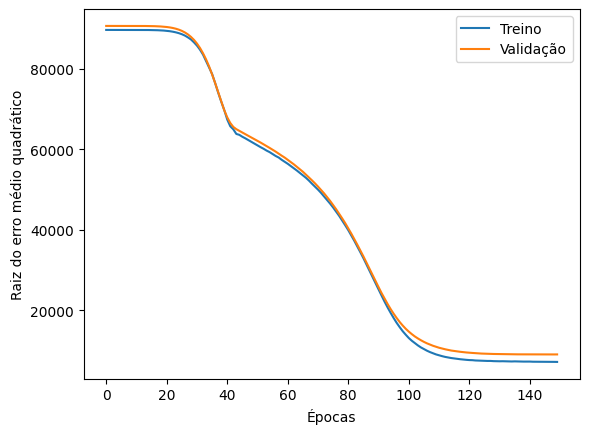

In [31]:
# MSE (RMSE) -> Quanto menor, melhor
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.xlabel('Épocas')
plt.ylabel('Raiz do erro médio quadrático')
plt.legend(['Treino','Validação'])

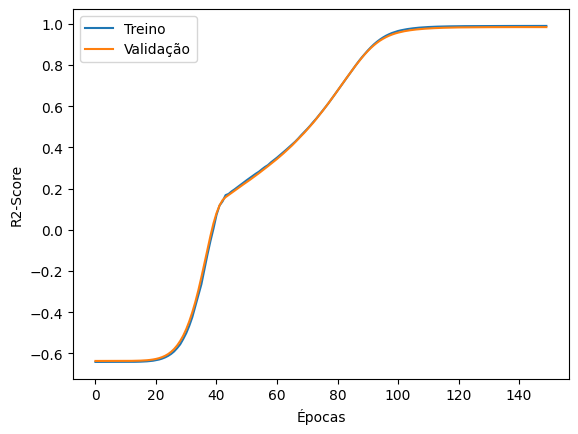

In [32]:
# R² Score -> Quanto maior, melhor
plt.plot(history.history['r2_score'])
plt.plot(history.history['val_r2_score'])
plt.xlabel('Épocas')
plt.ylabel('R2-Score')
plt.legend(['Treino','Validação'])

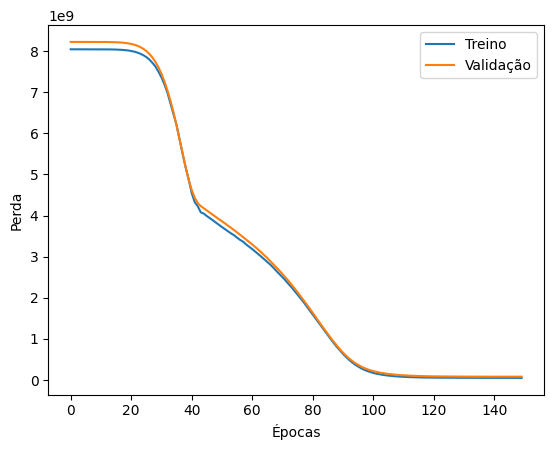

In [33]:
# Valor de perda -> Quanto menor, melhor
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend(['Treino','Validação'])

Text(0.5, 0, 'Rendimentos')

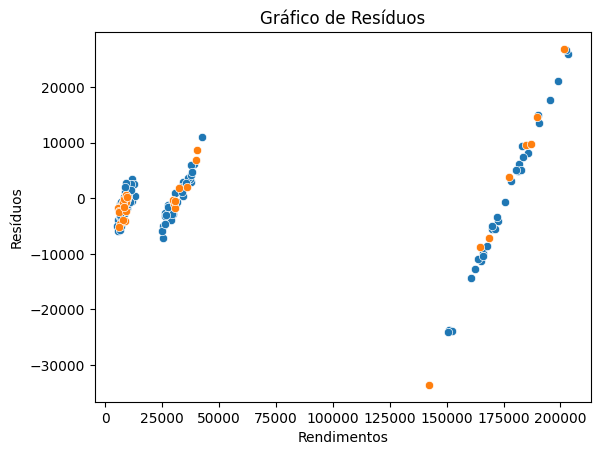

In [34]:
resid_train = y_train - predict_keras_train.reshape(-1) # flatten() tbm funciona para reduzir as dimensões do array
resid_test = y_test - predict_keras_test.reshape(-1)

sns.scatterplot(x=y_train, y=resid_train)
sns.scatterplot(x=y_test, y=resid_test)
plt.title("Gráfico de Resíduos")
plt.ylabel("Resíduos")
plt.xlabel("Rendimentos")

### Treinando o melhor modelo

Iremos treinar o melhor modelo baseado nas métricas adquiridas no processo de validação cruzada. O algorítmo de **Floresta Aleatória** foi o melhor modelo.

In [35]:
# Modelos como o de floresta aleatória não é necessário normalizar os dados

final_model_rf = RandomForestRegressor(random_state=SEED)
final_model_rf.fit(X, y)

joblib.dump(final_model_rf, 'random_forest_model.joblib')

['random_forest_model.joblib']

### Analisando o modelo treinado com a metodologia HoldOut

**Visualização dos resíduos**

In [36]:
rf_resid = model_rf_predict - y_test

Text(0, 0.5, 'Resíduos')

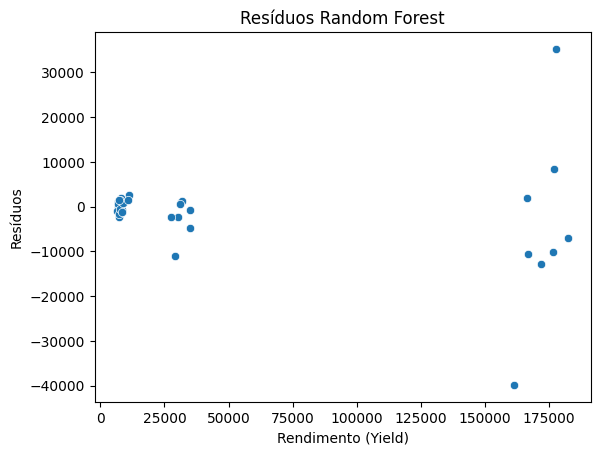

In [37]:
sns.scatterplot(x=model_rf_predict, y=rf_resid)
plt.title('Resíduos Random Forest')
plt.xlabel('Rendimento (Yield)')
plt.ylabel('Resíduos')

**Comparação de valores esperados VS valores previstos**

<Axes: >

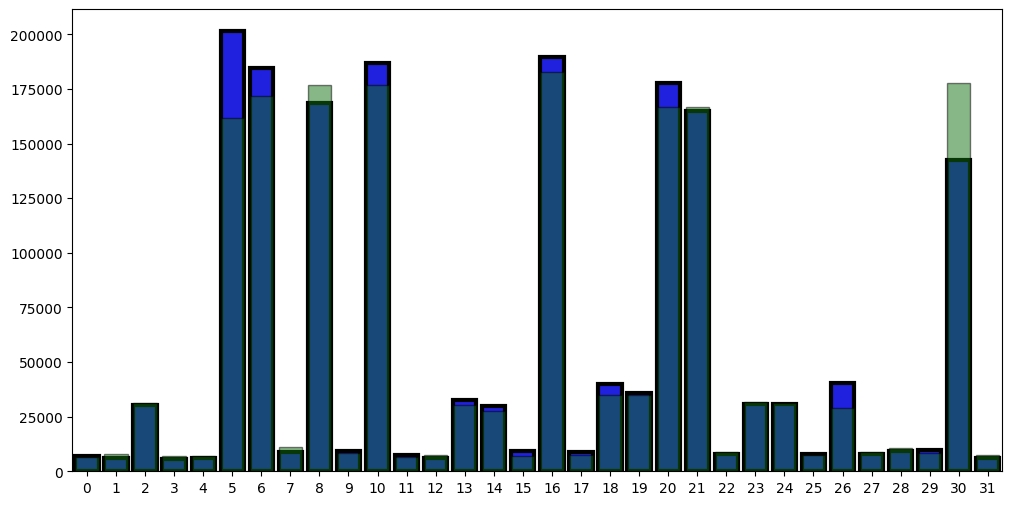

In [38]:
plt.figure(figsize=(12,6))
sns.barplot(np.array(y_test), color='blue', edgecolor='black', linewidth=3)
sns.barplot(model_rf_predict, color='green', alpha=0.5, edgecolor='black')

**Visualização da mesma coisa porém de valores mais baixos.**

Text(0.5, 0, 'Colheitas')

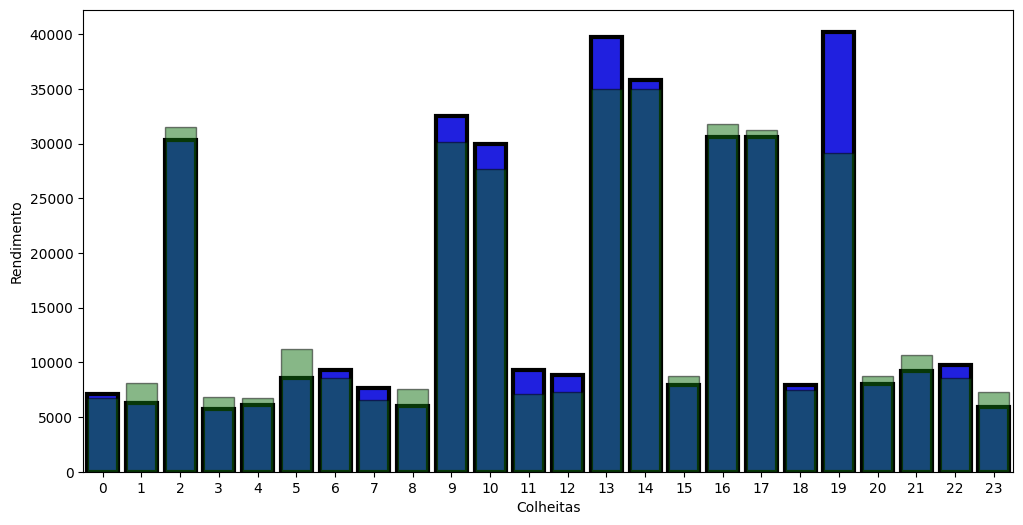

In [39]:
plt.figure(figsize=(12,6))
sns.barplot(np.array(y_test[y_test < 50000]), color='blue', edgecolor='black', linewidth=3)
sns.barplot(np.array(model_rf_predict[model_rf_predict < 50000]), color='green', alpha=0.5, edgecolor='black')
plt.ylabel('Rendimento')
plt.xlabel('Colheitas')

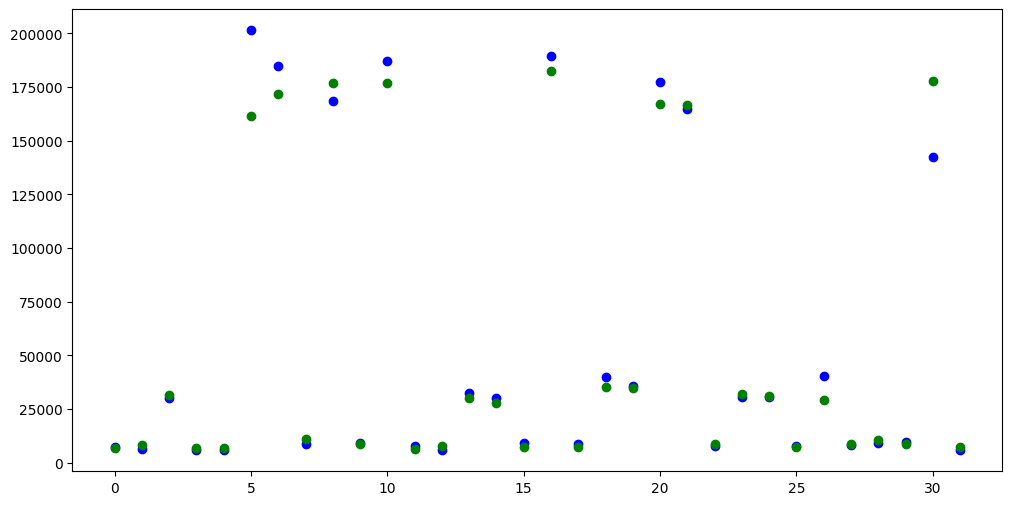

In [40]:
plt.figure(figsize=(12,6))
plt.scatter(range(len(y_test)), y_test, color='blue')
plt.scatter(range(len(y_test)), model_rf_predict, color='green')

<Axes: >

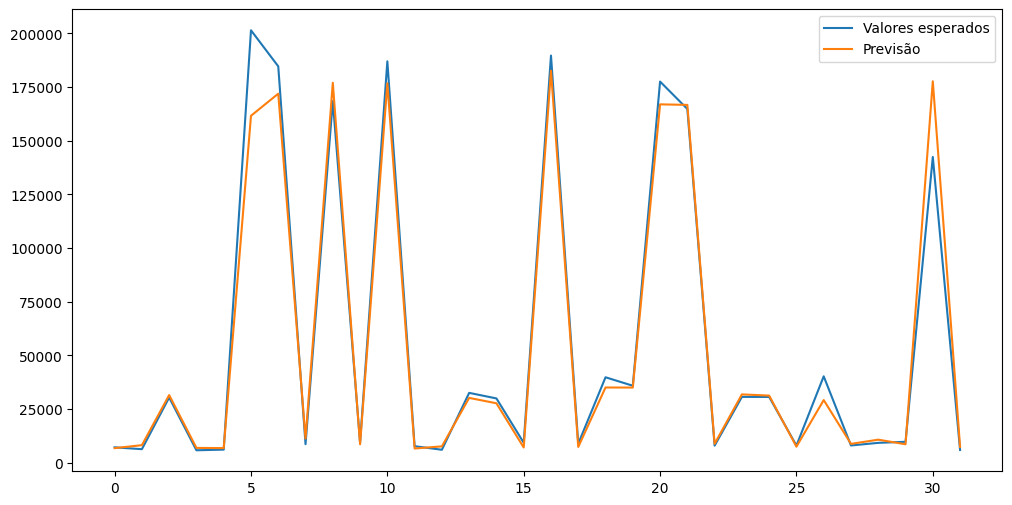

In [41]:
plt.figure(figsize=(12,6))
sns.lineplot(x=np.arange(0, len(y_test), 1), y=np.array(y_test), label='Valores esperados')
sns.lineplot(x=np.arange(0, len(y_test), 1), y=model_rf_predict, label='Previsão')

**Verificando como o modelo esta se ajustando aos dados de treinamento**

In [42]:
model_rf_predict_train = model_lr.predict(X_train)

<Axes: >

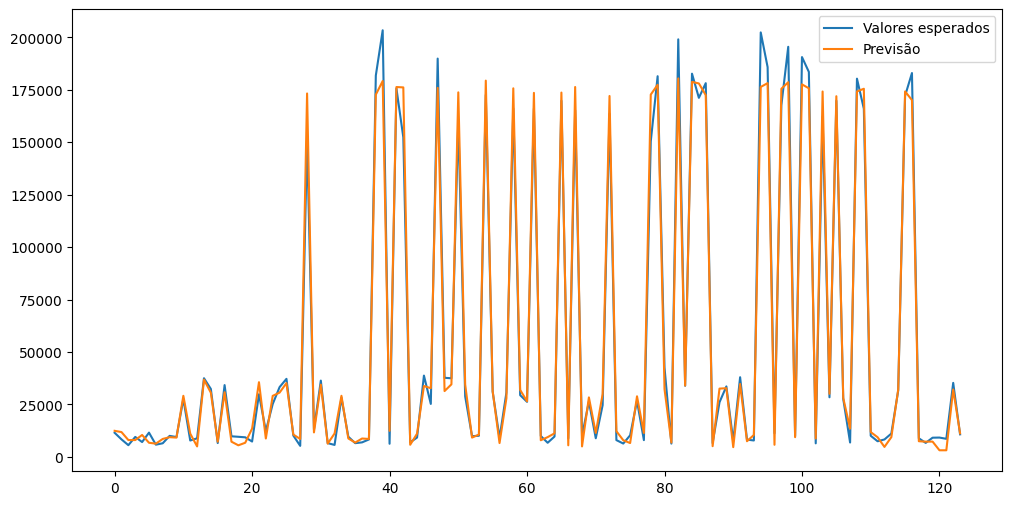

In [45]:
plt.figure(figsize=(12,6))
sns.lineplot(x=np.arange(0, len(y_train), 1), y=np.array(y_train), label='Valores esperados')
sns.lineplot(x=np.arange(0, len(y_train), 1), y=model_rf_predict_train, label='Previsão')